In [ ]:
%%capture
!pip install box2d-py

In [ ]:
import os
import cv2
import gym
import time
import collections

import numpy as np
import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
T.cuda.get_device_name()

'Tesla T4'

## **Network**

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, observation_shape, n_actions):
        super().__init__()
        # ANN
        self.fc1 = nn.Linear(observation_shape[0], 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)
        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(self.device)

    def forward(self, state):
        t = F.relu(self.fc1(state))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## **Agent**

In [ ]:
class PolicyGradientAgent:
    def __init__(self, observation_shape, n_actions, lr, gamma):
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.LR = lr
        self.GAMMA = gamma
        # MEMORY
        self.reward_memory = []
        self.action_logprobs_memory = []
        # POLICY
        self.policy = PolicyNetwork(lr, observation_shape, n_actions)
        
    def get_action(self, observation):
        observation = T.tensor(observation, dtype=T.float32).to(self.policy.device)
        state = T.unsqueeze(observation, 0)
        # PROB DISTRIBUTION
        probabilities = F.softmax(self.policy(state))
        action_distribution = T.distributions.Categorical(probabilities)
        # ACTION & LOG_PROB
        action = action_distribution.sample()
        logprob = action_distribution.log_prob(action)
        return action.item(), logprob

    def store_step(self, reward, logprob):
        self.reward_memory.append(reward)
        self.action_logprobs_memory.append(logprob)

    def learn(self):
        # G_t = R_t+1 + (gamma * R_t+2) + (gamma^2 * R_t+3) ...
        # SUM k = 0 to T {gamma^k * R_t+k+1}
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_t = 0
            for k in range(t, len(self.reward_memory)):
                G_t += (self.GAMMA**(k-t)) * self.reward_memory[k]
            G[t] = G_t
        G = T.tensor(G).to(self.policy.device)
        # LOSS CALC & BACKPROP
        loss = 0
        for G_t, logprob in zip(G, self.action_logprobs_memory):
            loss += -(G_t) * logprob
        self.policy.optimizer.zero_grad()
        loss.backward()
        self.policy.optimizer.step()
        #RESET
        self.reward_memory = []
        self.action_logprobs_memory = []

## **Training**

In [ ]:
env_name = "LunarLander-v2"
env = gym.make(env_name)

N_EPISODES = 3000

In [ ]:
agent = PolicyGradientAgent(observation_shape=env.observation_space.shape,
                            n_actions=env.action_space.n,
                            lr=5e-4,                        # SMALL TO PREVENT LARGE CHANGES IN POLICY
                            gamma=0.99)

In [ ]:
asepisode_rewards, episode_lengths, mean_rewards = [],[],[]
best_reward = -np.inf

for episode_n in tqdm(range(N_EPISODES)):
    total_reward, total_moves = 0,0

    done = False
    observation = env.reset()

    while not done:
        action, logprob = agent.get_action(observation)
        observation_, reward, done, _ = env.step(action)

        agent.store_step(reward, logprob)
        total_reward += reward
        total_moves += 1
        
        observation = observation_
    
    episode_rewards.append(total_reward)
    episode_lengths.append(total_moves)

    agent.learn()

    mean_reward = np.mean(episode_rewards[-100:])
    mean_rewards.append(mean_reward)
    if(mean_reward > best_reward):
        best_reward = mean_reward

    print("ITER: ",episode_n,"\tRWD: ",round(total_reward,2),"\tM_RWD: ",round(mean_reward,2),"\tLEN: ",total_moves)

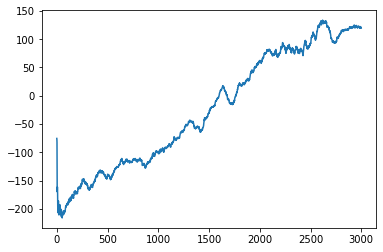

In [ ]:
plt.plot(mean_rewards)